# Uncertainties in python (simple examples)

(from the Example in the guides prepared by Dirk)

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.

## Ratio of quantities

Determine $R=\frac{Y(511\,\text{keV})}{2Y(1275\,\text{keV})}$


In [2]:
Y1 = [ufloat(203500, sqrt(203500)),
      ufloat(220100, sqrt(220100)),
      ufloat(157400, sqrt(157400)),
      ufloat(188300, sqrt(188300))]
Y2 = [ufloat(115500, sqrt(115500)),
      ufloat(121100, sqrt(121100)),
      ufloat(89100, sqrt(89100)),
      ufloat(107200, sqrt(107200))]

In [3]:
sum = 0
for i in range(len(Y1)):
    ratio = Y1[i] / (2 * Y2[i])
    sum += ratio * 0.25
    print("ratio {}: {:.2uS}".format(i, ratio))  # 2 digits in unceirtainty, Short hand notation
print("average: {:.2uS}".format(sum))

ratio 0: 0.8810(32)
ratio 1: 0.9088(33)
ratio 2: 0.8833(37)
ratio 3: 0.8783(34)
average: 0.8878(17)


## Calibration

Here we also show another way to input values with unceirtanties

In [4]:
from uncertainties import ufloat_fromstr

y_i = [
    ufloat_fromstr("279.2"),
    ufloat_fromstr("511.0"),
    ufloat_fromstr("1274.5"),
    ufloat_fromstr("2614.5"),
]
x_i = [
    ufloat_fromstr("107.1(5)"),
    ufloat_fromstr("180.1(7)"),
    ufloat_fromstr("421.3(11)"),
    ufloat_fromstr("841.9(18)"),
]

y = [i.n for i in y_i]  # n -> nominal value
dy = [i.s for i in y_i]  # s -> standard deviation

x = [i.n for i in x_i]  # n -> nominal value
dx = [i.s for i in x_i]  # s -> standard deviation

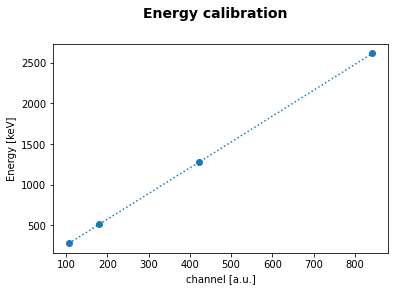

In [6]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
fig.suptitle("Energy calibration", fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)

ax.set_xlabel("channel [a.u.]")
ax.set_ylabel("Energy [keV]")

# plot dots
plt.scatter(x, y)
#plot with error bars. OBS: They are smaller than the scatter dot.
plt.errorbar(x, y, xerr=dx, yerr=dy, linestyle=':')

plt.show()

# Let's so some fitting

## Attempt 1: (WRONG ONE) No errors included
### Using linregress - Pico does not approve ;-)

In [7]:
from scipy import stats
import numpy as np

b, a, r_value, p_value, std_err = stats.linregress(x, y)
print(" E = {:.1f}*ch + {:.1f}".format(b, a))
## not a clue on how to estimate the errors =(
## I think std_err it is the error of the slope only, error for offset?

 E = 3.2*ch + -62.0


## Attempt 2: (STILL WRONG) Errors only in one axis
### Using curve_fit - Pico approves ;-)

In [10]:
import numpy as np
from scipy import optimize


def f(x, a, b):
    "a line"
    return a + b * x


def ff(x, p):
    "helper function"
    return f(x, *p)


# initial guesses
a = 0
b = 1

pstart = [a, b]


def fit_curvefit(p0, datax, datay, function, yerr=None, **kwargs):
    "Generic fitting function for when one has errors or not in the input data"

    if yerr is not None:
        pfit, pcov = optimize.curve_fit(f, datax, datay, p0=p0, sigma=yerr, epsfcn=0.0001, **kwargs)
    else:
        pfit, pcov = optimize.curve_fit(f, datax, datay, p0=p0, epsfcn=0.0001, **kwargs)

    error = []
    for i in range(len(pfit)):
        try:
            error.append(np.absolute(pcov[i][i]) ** 0.5)
        except:
            error.append(0.00)
    pfit_curvefit = pfit
    perr_curvefit = np.array(error)
    return pfit_curvefit, perr_curvefit

pfit, perr = fit_curvefit(pstart, x, y, ff)

print("\n# Fit parameters and parameter errors from curve_fit method :")
print("pfit = ", pfit)
print("perr = ", perr)
a = ufloat(pfit[0], perr[0])
b = ufloat(pfit[1], perr[1])
print("a = {:S}".format(a))
print("b = {:S}".format(b))

E = a + 227.3 * b
print("E = {:S}".format(E))

pfit, perr = fit_curvefit(pstart, x, y, ff, dy)

print("\n# Fit parameters and parameter errors from curve_fit method :")
print("pfit = ", pfit)
print("perr = ", perr)
a = ufloat(pfit[0], perr[0])
b = ufloat(pfit[1], perr[1])
print("a = {:S}".format(a))
print("b = {:S}".format(b))

E = a + 227.3 * b
print("E = {:S}".format(E))


### Results with y-errors included
# Fit parameters and parameter errors from curve_fit method :
#pfit =  [-61.96861944   3.17793761]
#perr =  [1.65069473 0.00342302]
#a = -62.0(1.7)
#b = 3.1779(34)
#E = 660.4(1.8)

## The unceirtainties are on x... 
#the results including unceirtanties in y are not suprisingly
# IDENTICAL



# Fit parameters and parameter errors from curve_fit method :
pfit =  [-61.96861944   3.17793761]
perr =  [1.65069473 0.00342302]
a = -62.0(1.7)
b = 3.1779(34)
E = 660.4(1.8)

# Fit parameters and parameter errors from curve_fit method :
pfit =  [-61.96861944   3.17793761]
perr =  [1.65069473 0.00342302]
a = -62.0(1.7)
b = 3.1779(34)
E = 660.4(1.8)


## Attempt 4: error on both axes 

Unlike the previous example, we do not use the curve_fit module of Scipy, Instead, there is  another  dedicated module to estimate the orthogonal distance regression (odr). The program with some comments is shown below:

fit parameter 1-sigma error
———————————–
-61.03 +/-   0.97
  3.18 +/-   0.00

a = -61.0(1.0)
b = 3.175(4)
E = 660.7(2.9)


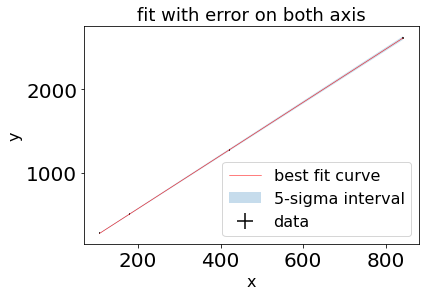

In [64]:
import numpy as np
from pylab import *
from scipy.optimize import curve_fit
from scipy import odr


def func(p, x):
    "function to fit"
    a, b = p
    return a + b * x


# Model object
quad_model = odr.Model(func)

# Create a RealData object
data = odr.RealData(x, y, sx=dx, sy=dy)

# Set up ODR with the model and data.
odr = odr.ODR(data, quad_model, beta0=[0., 1.])  # initial guess of parameters

# Run the regression.
out = odr.run()

#print fit parameters and 1-sigma estimates
popt = out.beta
perr = out.sd_beta
print('fit parameter 1-sigma error')
print('———————————–')
for i in range(len(popt)):
    print("{:6.2f} +/- {:6.2f}".format(popt[i], perr[i]))
print()

a = ufloat(popt[0], perr[0])
b = ufloat(popt[1], perr[1])
print("a = {:uS}".format(a))
print("b = {:uS}".format(b))

ch = ufloat_fromstr("227.3(8)")
E = a + ch * b
print("E = {:uS}".format(E))

# prepare confidence level curves
nstd = 5.  # to draw 5-sigma intervals
popt_up = popt + nstd * perr
popt_dw = popt - nstd * perr

x_fit = np.linspace(min(x), max(x), 100)
fit = func(popt, x_fit)
fit_up = func(popt_up, x_fit)
fit_dw = func(popt_dw, x_fit)

#plot
fig, ax = plt.subplots(1)
rcParams['font.size'] = 20
xlabel('x', fontsize=16)
ylabel('y', fontsize=16)
title('fit with error on both axis', fontsize=18)
## plot points with errors in both axes
errorbar(x, y, yerr=dy, xerr=dx, ecolor='k', fmt='none', label='data')
## plot line corresponding to fit
plot(x_fit, fit, 'r', lw=0.5, label='best fit curve')
## color a 5 sigma region to the fit 
ax.fill_between(x_fit, fit_up, fit_dw, alpha=.25, label='5-sigma interval')
legend(loc='lower right', fontsize=16)
show()
## OBS: 5-sigma thickness is comparable/smaller with best fit sigma

# Comparing this to Dirk's original manual

In [63]:
from uncertainties import ufloat_fromstr

print("Using equal weights")
a = ufloat_fromstr("-62.0(17)")  # Short-hand notation
b = ufloat_fromstr("3.1779(36)")
E = a + 227.3 * b
print("calibrated energy = {:.2uS}\n".format(E))
# 660.3(1.9)
# looks good.
# This is compatible to 660.4(1.8) from Attempt 2

print("Using weights from measurement")
a = ufloat_fromstr("-61.0(6)")  # Short-hand notation
b = ufloat_fromstr("3.1752(22)")
ch = ufloat_fromstr("227.3(8)")
E = a + ch * b
print("calibrated energy = {:.2uS}\n".format(E))
# 660.7(2.7)
# Looks good when including the unceirtainty of the peak position.
# This is compatible to 660.7(2.9) from Attempt 3

Using equal weights
calibrated energy = 660.3(1.9)

Using weights from measurement
calibrated energy = 660.7(2.7)

